In [0]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow import keras
import os
import numpy as np
import pickle, bz2
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

%matplotlib inline

Using TensorFlow backend.


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
!wget nc https://github.com/cristianru31/dataset_kaggle/blob/master/kaggle_json.zip?raw=true -O kaggle_json.zip
!unzip kaggle_json.zip

In [0]:
from google.colab import files
!ls -lha kaggle.json
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
!unzip alzheimers-dataset-4-class-of-images.zip

# Data pre-processing

In [0]:
TRAIN_DIR = 'Alzheimer_s Dataset/train/'
TEST_DIR = 'Alzheimer_s Dataset/test/'
IMAGE_SIZE = 176
CLASSES = ['NonDemented','VeryMildDemented','MildDemented']

train_images = []
test_images = []
train_labels = []
test_labels = []

i=0
for klass in CLASSES:
    
  print(klass)

  #Train
  train_labels.append(np.ones(len(os.listdir(TRAIN_DIR + klass)))*i)
  for image in os.listdir(TRAIN_DIR + klass):
    img_aux=img.imread(TRAIN_DIR + klass + '/' + image)
    train_images.append(img_aux)

  #Test
  test_labels.append(np.ones(len(os.listdir(TEST_DIR + klass)))*i)
  for image in os.listdir(TEST_DIR + klass):
    img_aux=img.imread(TEST_DIR + klass + '/' + image)
    test_images.append(img_aux)

  i+=1

train_labels = np.concatenate(train_labels)
test_labels = np.concatenate(test_labels)

print('Data Train: ',np.shape(train_images))
print('Data Test: ',np.shape(test_images))
print('Labels Train: ',np.shape(train_labels))
print('Labels Test: ',np.shape(test_labels))


NonDemented
VeryMildDemented
MildDemented
Data Train:  (5069, 208, 176)
Data Test:  (1267, 208, 176)
Labels Train:  (5069,)
Labels Test:  (1267,)


In [0]:
x_train=np.array(train_images)
x_test=np.array(test_images)
y_train=np.array(train_labels)
y_test=np.array(test_labels)

In [0]:
y_test.shape, y_train.shape, x_test.shape, x_train.shape

((1267,), (5069,), (1267, 208, 176), (5069, 208, 176))

In [0]:
x_train=x_train.reshape((-1, x_train.shape[1], x_train.shape[2], 1))
x_test=x_test.reshape((-1, x_test.shape[1], x_test.shape[2], 1))
y_test.shape, y_train.shape, x_test.shape, x_train.shape

((1267,), (5069,), (1267, 208, 176, 1), (5069, 208, 176, 1))

# MODEL 1

In [0]:
def get_model(num_classes, compile=True, reg=.0001, drop=0.4):

    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(208,176,1), name="input_1")
    layers = tf.keras.layers.Conv2D(32,(4,4), activation="relu", kernel_regularizer=l2(reg))(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Conv2D(64,(4,4), activation="relu")(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model


In [0]:
num_classes = len(np.unique(train_labels))

model1 = get_model(num_classes=num_classes,reg=.0001, drop=0.4)
model1.summary()

using 3 classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 208, 176, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 205, 173, 32)      544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 102, 86, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 102, 86, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 83, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 41, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 49, 41, 6

In [0]:
tb_callback = keras.callbacks.TensorBoard(log_dir='model1_3c', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model1.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True,
          validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0427 16:13:25.167624 140159746295616 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0427 16:13:25.168510 140159746295616 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5069 samples, validate on 1267 samples
Epoch 1/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.0818 - accuracy: 0.5546
Epoch 00001: val_loss improved from inf to 0.92382, saving model to /home/cristian/Cristian/Deep_learning/modelos_3c/model1/best_model1.hdf5
5069/5069 [==============================] - 121s 24ms/sample - loss: 1.0825 - accuracy: 0.5543 - val_loss: 0.9238 - val_accuracy: 0.5722
Epoch 2/20
5056/5069 [============================>.] - ETA: 0s - loss: 0.5201 - accuracy: 0.7870
Epoch 00002: val_loss did not improve from 0.92382
5069/5069 [==============================] - 121s 24ms/sample - loss: 0.5199 - accuracy: 0.7871 - val_loss: 1.5219 - val_accuracy: 0.5304
Epoch 3/20
5056/5069 [============================>.] - ETA: 0s - loss: 0.2840 - accuracy: 0.8960
Epoch 00003: val_loss did not improve from 0.92382
5069/5069 [==============================] - 121s 24ms/sample - loss: 0.2838 - accuracy: 0.8960 - val_loss: 1.2241 - val_accuracy: 0.5635
E

In [0]:
#Load the weights of the best stored model
model1.load_weights('best_model1.hdf5')

Normalized confusion matrix
[[0.78125    0.1875     0.03125   ]
 [0.48214286 0.46205357 0.05580357]
 [0.36312849 0.53631285 0.10055866]]


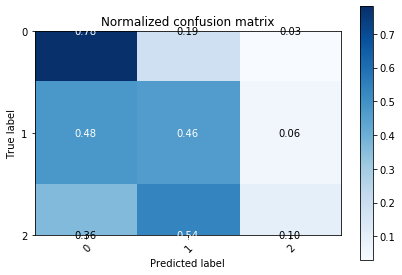

In [0]:
test_preds = model1.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.5722178374112076
Accuracy Balanceado: 0.4479540768821495


# MODEL 2

In [0]:
def get_model(num_classes, compile=True, reg=.0001, drop=0.4):

    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(208,176,1), name="input_1")
    layers = tf.keras.layers.Conv2D(32,(4,4), activation="relu", kernel_regularizer=l2(reg))(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Conv2D(64,(4,4), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Conv2D(128,(5,5), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [0]:
num_classes = len(np.unique(train_labels))

model2 = get_model(num_classes=num_classes ,reg=0.0001, drop=0.4)
model2.summary()

using 3 classes
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 208, 176, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 205, 173, 32)      544       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 102, 86, 32)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 102, 86, 32)       128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 99, 83, 64)        32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 41, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 49, 41,

In [0]:
tb_callback = keras.callbacks.TensorBoard(log_dir='model2_3c', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_model2.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model2.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True, validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0427 16:54:01.959536 140159746295616 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0427 16:54:01.960325 140159746295616 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5069 samples, validate on 1267 samples
Epoch 1/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.2230 - accuracy: 0.5427
Epoch 00001: val_loss improved from inf to 2.30184, saving model to /home/cristian/Cristian/Deep_learning/modelos_3c/model2/best_model2.hdf5
5069/5069 [==============================] - 171s 34ms/sample - loss: 1.2224 - accuracy: 0.5429 - val_loss: 2.3018 - val_accuracy: 0.3544
Epoch 2/20
5056/5069 [============================>.] - ETA: 0s - loss: 0.8926 - accuracy: 0.6568
Epoch 00002: val_loss improved from 2.30184 to 1.74309, saving model to /home/cristian/Cristian/Deep_learning/modelos_3c/model2/best_model2.hdf5
5069/5069 [==============================] - 169s 33ms/sample - loss: 0.8933 - accuracy: 0.6563 - val_loss: 1.7431 - val_accuracy: 0.3023
Epoch 3/20
5056/5069 [============================>.] - ETA: 0s - loss: 0.7146 - accuracy: 0.7534
Epoch 00003: val_loss improved from 1.74309 to 1.25459, saving model to /home/cristian/Cristian/

In [0]:
#Load the weights of the best stored model
model2.load_weights('best_model2.hdf5')

Normalized confusion matrix
[[0.79375    0.20625    0.        ]
 [0.31473214 0.68526786 0.        ]
 [0.38547486 0.5698324  0.04469274]]


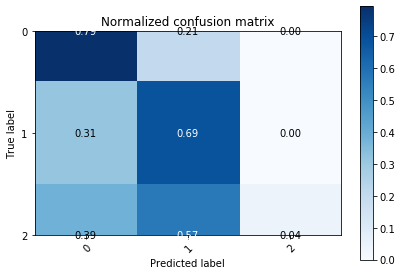

In [0]:
test_preds = model2.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.6495659037095501
Accuracy Balanceado: 0.5079035315243415


# MODEL 3

In [0]:
def get_model(num_classes, compile=True, reg=.0001, drop=0.4):

    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(208,176,1), name="input_1")
    layers = tf.keras.layers.Conv2D(32,(4,4), activation="relu", kernel_regularizer=l2(reg))(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Conv2D(64,(4,4), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Conv2D(128,(5,5), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [0]:
model3 = get_model(num_classes=num_classes,reg=.0001, drop=0.4)
model3.summary()

using 3 classes
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 208, 176, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 205, 173, 32)      544       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 102, 86, 32)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 102, 86, 32)       128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 99, 83, 64)        32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 41, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 49, 41,

In [0]:
tb_callback = keras.callbacks.TensorBoard(log_dir='model3_3c', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_model3.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model3.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True,
          validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0427 17:50:42.953490 140159746295616 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0427 17:50:42.954329 140159746295616 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5069 samples, validate on 1267 samples
Epoch 1/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.3465 - accuracy: 0.4634
Epoch 00001: val_loss improved from inf to 1.11147, saving model to /home/cristian/Cristian/Deep_learning/modelos_3c/model3/best_model3.hdf5
5069/5069 [==============================] - 172s 34ms/sample - loss: 1.3465 - accuracy: 0.4632 - val_loss: 1.1115 - val_accuracy: 0.4830
Epoch 2/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.0293 - accuracy: 0.5742
Epoch 00002: val_loss improved from 1.11147 to 0.97035, saving model to /home/cristian/Cristian/Deep_learning/modelos_3c/model3/best_model3.hdf5
5069/5069 [==============================] - 171s 34ms/sample - loss: 1.0292 - accuracy: 0.5741 - val_loss: 0.9704 - val_accuracy: 0.6030
Epoch 3/20
5056/5069 [============================>.] - ETA: 0s - loss: 0.9230 - accuracy: 0.6268
Epoch 00003: val_loss did not improve from 0.97035
5069/5069 [==============================] - 

In [0]:
#Load the weights of the best stored model
model3.load_weights('best_model3.hdf5')

Normalized confusion matrix
[[0.9046875  0.0859375  0.009375  ]
 [0.58928571 0.38392857 0.02678571]
 [0.41899441 0.50837989 0.0726257 ]]


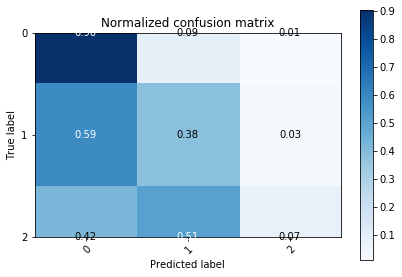

In [0]:
test_preds = model3.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.6029992107340174
Accuracy Balanceado: 0.45374725658419796


# MODEL 4

In [0]:
def get_model(num_classes, compile=True, reg=.0001, drop=0.4):

    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(208,176,1), name="input_1")
    layers = tf.keras.layers.Conv2D(16,(2,2), activation="relu", kernel_regularizer=l2(reg))(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Conv2D(32,(4,4), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Conv2D(64,(4,4), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Conv2D(128,(5,5), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [0]:
model4 = get_model(num_classes=num_classes,reg=.0001, drop=0.4)
model4.summary()

using 3 classes
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 208, 176, 1)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 207, 175, 16)      80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 103, 87, 16)       0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 103, 87, 16)       64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 84, 32)       8224      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 42, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 50, 42,

In [0]:
tb_callback = keras.callbacks.TensorBoard(log_dir='model4_3c', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_model4.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model4.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True,
          validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0427 18:47:29.577043 140159746295616 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0427 18:47:29.577801 140159746295616 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5069 samples, validate on 1267 samples
Epoch 1/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.4724 - accuracy: 0.4395
Epoch 00001: val_loss improved from inf to 1.59936, saving model to /home/cristian/Cristian/Deep_learning/modelos_3c/model4/best_model4.hdf5
5069/5069 [==============================] - 77s 15ms/sample - loss: 1.4714 - accuracy: 0.4395 - val_loss: 1.5994 - val_accuracy: 0.5146
Epoch 2/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.1369 - accuracy: 0.5047
Epoch 00002: val_loss improved from 1.59936 to 1.00000, saving model to /home/cristian/Cristian/Deep_learning/modelos_3c/model4/best_model4.hdf5
5069/5069 [==============================] - 76s 15ms/sample - loss: 1.1363 - accuracy: 0.5046 - val_loss: 1.0000 - val_accuracy: 0.5225
Epoch 3/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.0080 - accuracy: 0.5548
Epoch 00003: val_loss improved from 1.00000 to 0.97676, saving model to /home/cristian/Cristian/De

In [0]:
#Load the weights of the best stored model
model4.load_weights('best_model4.hdf5')

Normalized confusion matrix
[[0.8609375  0.1296875  0.009375  ]
 [0.41517857 0.54910714 0.03571429]
 [0.30726257 0.48044693 0.2122905 ]]


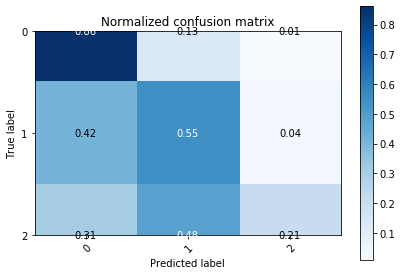

In [0]:
test_preds = model4.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.659037095501184
Accuracy Balanceado: 0.5407783818834796


In [0]:
try:
    %load_ext tensorboard
    %tensorboard --logdir logs

except:
    print ("not in colab")

Reusing TensorBoard on port 6007 (pid 29689), started 18:05:22 ago. (Use '!kill 29689' to kill it.)